# AWS-AlphaFold Notebook

This notebook allows you to easily predict the structure of a protein using a modified version of [AlphaFold v2.1.0](https://doi.org/10.1038/s41586-021-03819-2). 

**Differences to AlphaFold v2.1.0**

In comparison to AlphaFold v2.1.0, this notebook uses AWS Batch to submit protein analysis jobs to a scalable compute cluster. The accuracy should be the same as if you ran it locally. However, by using HPC services like AWS Batch and Amazon FSx for Lustre, we can support parallel job execution and optimize the resources for each run.

**Citing this work**

Any publication that discloses findings arising from using this notebook should [cite](https://github.com/deepmind/alphafold/#citing-this-work) the [AlphaFold paper](https://doi.org/10.1038/s41586-021-03819-2).

**Licenses**

This notebook uses the [AlphaFold model parameters](https://github.com/deepmind/alphafold/#model-parameters-license) and its outputs are thus for non-commercial use only, under the Creative Commons Attribution-NonCommercial 4.0 International ([CC BY-NC 4.0](https://creativecommons.org/licenses/by-nc/4.0/legalcode)) license. The notebook itself is provided under the [MIT 0 license](https://github.com/aws/mit-0). 

**More information**

You can find more information about how AlphaFold works in the following papers:

*   [AlphaFold methods paper](https://www.nature.com/articles/s41586-021-03819-2)
*   [AlphaFold predictions of the human proteome paper](https://www.nature.com/articles/s41586-021-03828-1)
*   [AlphaFold-Multimer paper](https://www.biorxiv.org/content/10.1101/2021.10.04.463034v1)

FAQ on how to interpret AlphaFold predictions are [here](https://alphafold.ebi.ac.uk/faq).

## Install dependencies

In [ ]:
%pip install -r notebook-requirements.txt -q -q

In [7]:
 ## Import helper functions at rfutils/rfutils.py
from nbhelpers import nbhelpers

# Import required Python packages
from alphafold.notebooks import notebook_utils
from alphafold.model import config
import boto3
from datetime import datetime
import sagemaker
import pandas as pd
import os

pd.set_option("max_colwidth", None)

# Get client informatiion
boto_session = boto3.session.Session()
sm_session = sagemaker.session.Session()
region = boto_session.region_name
s3_client = boto3.client("s3", region_name=region)
batch_client = boto3.client("batch")
default_bucket = sm_session.default_bucket()
print(f"Default S3 bucket name is {default_bucket}")

S3_BUCKET = default_bucket


Default S3 bucket name is sagemaker-us-east-2-032243382548


## Manage Stacks

If you have multiple AWS-Alphafold stacks deployed in your account, which one should we use?

In [2]:
nbhelpers.list_alphafold_stacks()

[{'StackId': 'arn:aws:cloudformation:us-east-2:032243382548:stack/awsaf-220114/666593a0-754c-11ec-bde9-06bb81706e18',
  'StackName': 'awsaf-220114',
  'TemplateDescription': 'Creates a stack for running Alphafold on AWS Batch.',
  'CreationTime': datetime.datetime(2022, 1, 14, 15, 12, 33, 908000, tzinfo=tzutc()),
  'StackStatus': 'CREATE_COMPLETE',
  'DriftInformation': {'StackDriftStatus': 'NOT_CHECKED'}},
 {'StackId': 'arn:aws:cloudformation:us-east-2:032243382548:stack/awsaf-220110/51040f60-7230-11ec-b255-06d9eacc2886',
  'StackName': 'awsaf-220110',
  'TemplateDescription': 'Creates a stack for running Alphafold on AWS Batch.',
  'CreationTime': datetime.datetime(2022, 1, 10, 16, 13, 58, 656000, tzinfo=tzutc()),
  'LastUpdatedTime': datetime.datetime(2022, 1, 13, 17, 43, 20, 420000, tzinfo=tzutc()),
  'StackStatus': 'UPDATE_COMPLETE',
  'DriftInformation': {'StackDriftStatus': 'NOT_CHECKED'}}]

## (One-Time Setup) Populate File System

In [3]:
# Pick the stack to populate
new_stack = "awsaf-220114"

In [4]:
## Note: You only need to do this once!
nbhelpers.submit_download_data_job(
    job_name="download_job",
    script="scripts/download_all_data.sh",
    cpu=4,
    memory=16,
    stack_name = new_stack,
    download_dir = "/fsx",
    download_mode = "reduced_dbs",
    )

{'ResponseMetadata': {'RequestId': '5489c71f-2263-4742-8fa8-a6c229773f71',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Fri, 14 Jan 2022 15:27:15 GMT',
   'content-type': 'application/json',
   'content-length': '162',
   'connection': 'keep-alive',
   'x-amzn-requestid': '5489c71f-2263-4742-8fa8-a6c229773f71',
   'access-control-allow-origin': '*',
   'x-amz-apigw-id': 'L8RtFGbMiYcF-gQ=',
   'access-control-expose-headers': 'X-amzn-errortype,X-amzn-requestid,X-amzn-errormessage,X-amzn-trace-id,X-amz-apigw-id,date',
   'x-amzn-trace-id': 'Root=1-61e19653-35000c3213a0747e4bc09ada'},
  'RetryAttempts': 0},
 'jobArn': 'arn:aws:batch:us-east-2:032243382548:job/4be1fe60-0458-4254-9309-412fa2556241',
 'jobName': 'download_job',
 'jobId': '4be1fe60-0458-4254-9309-412fa2556241'}

## Making a prediction

Please paste the sequence of your protein in the text box below, then run the remaining cells via _Runtime_ > _Run after_. You can also run the cells individually by pressing the _Play_ button on the left.

Note that the search against databases and the actual prediction can take some time, from minutes to hours, depending on the length of the protein and what type of GPU you are allocated by Colab (see FAQ below).

Provide sequences for analysis

In [ ]:
my_stack = "awsaf-220110"

In [ ]:
## Enter the amino acid sequence to fold 

########### Required Inputs #################################
id_1 = "T1084"
sequence_1 = "MAAHKGAEHHHKAAEHHEQAAKHHHAAAEHHEKGEHEQAAHHADTAYAHHKHAEEHAAQAAKHDAEHHAPKPH"
#################################################

id_2 = ''
sequence_2 = ''
id_3 = ''
sequence_3 = ''
id_4 = ''
sequence_4 = ''
id_5 = ''
sequence_5 = ''
id_6 = ''
sequence_6 = ''
id_7 = ''
sequence_7 = ''
id_8 = ''
sequence_8 = ''

input_ids = (id_1, id_2, id_3, id_4,
                   id_5, id_6, id_7, id_8)
input_sequences = (sequence_1, sequence_2, sequence_3, sequence_4,
                   sequence_5, sequence_6, sequence_7, sequence_8)


# If folding a complex target and all the input sequences are
# prokaryotic then set `is_prokaryotic` to `True`. Set to `False`
# otherwise or if the origin is unknown.
IS_PROKARYOTE = False  

MIN_SINGLE_SEQUENCE_LENGTH = 16
MAX_SINGLE_SEQUENCE_LENGTH = 2500
MAX_MULTIMER_LENGTH = 2500
MAX_TEMPLATE_DATE = "2022-01-01"
DB_PRESET = "reduced_dbs"
RUN_FEATURES_ONLY = False
BENCHMARK = False
USE_PRECOMPUTED_MSAS = False    

Validate the input and determine which models to use.

In [ ]:
sequences, model_type_to_use = notebook_utils.validate_input(
    input_sequences=input_sequences,
    min_length=MIN_SINGLE_SEQUENCE_LENGTH,
    max_length=MAX_SINGLE_SEQUENCE_LENGTH,
    max_multimer_length=MAX_MULTIMER_LENGTH)

if model_type_to_use == notebook_utils.ModelType.MONOMER:
    model_preset = "monomer"
    model_names = config.MODEL_PRESETS['monomer'] + ('model_2_ptm',)
elif model_type_to_use == notebook_utils.ModelType.MULTIMER:
    model_preset = "multimer"
    model_names = config.MODEL_PRESETS['multimer']

Upload input file to S3

In [ ]:
job_name = nbhelpers.create_job_name()
object_key = nbhelpers.upload_fasta_to_s3(sequences, input_ids, S3_BUCKET, job_name, region=region)    

Submit AWS Batch job

In [ ]:
batch_resources = nbhelpers.get_batch_resources()

response = nbhelpers.submit_batch_alphafold_job(
    job_definition=batch_resources["gpu_job_definition"],
    job_name=str(job_name),
    job_queue=batch_resources["gpu_job_queue"],
    fasta_paths = object_key,
    output_dir = job_name,
    db_preset = DB_PRESET,
    model_preset = model_preset,
    s3_bucket = S3_BUCKET,
    cpu = 8,
    memory = 16,
    gpu = 1,
    stack_name = my_stack,
)

print(f"Job ID {response['jobId']} submitted")

Check status of jobs

In [ ]:
status = nbhelpers.get_batch_job_info(response['jobId'])
print(f"Job {status['jobName']} is in {status['status']} status")

View job logs

In [ ]:
nbhelpers.get_batch_logs(status["logStreamName"])

## View Results

View MSA information

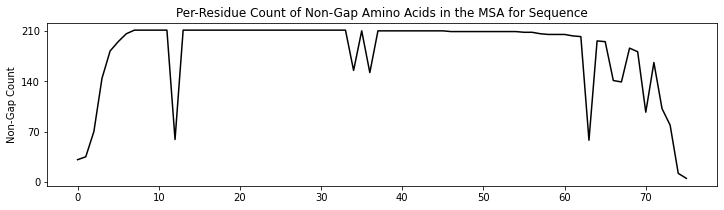

In [9]:
job_name="20220113T162425"
nbhelpers.plot_msa(S3_BUCKET, job_name)

View predicted structure

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

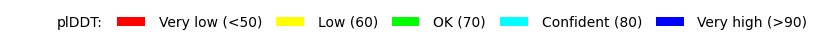

In [10]:
nbhelpers.display_structure(S3_BUCKET, job_name, vmin=0.5, vmax=0.9)

## Two-step job

In [ ]:
job_name = nbhelpers.create_job_name()
object_key = nbhelpers.upload_fasta_to_s3(sequences, input_ids, S3_BUCKET, job_name, region=region)

In [ ]:
step_1_response = nbhelpers.submit_batch_alphafold_job(
    job_name=str(job_name),
    fasta_paths = object_key,
    output_dir = job_name,
    db_preset = DB_PRESET,
    model_preset = model_preset,
    s3_bucket = S3_BUCKET,
    cpu = 8,
    memory = 32,
    gpu = 0,
    run_features_only = True,
    stack_name = my_stack,
)

print(f"Job ID {step_1_response['jobId']} submitted")

step_2_response = nbhelpers.submit_batch_alphafold_job(
    job_name=str(job_name),
    fasta_paths = object_key,
    output_dir = job_name,
    db_preset = DB_PRESET,
    model_preset = model_preset,
    s3_bucket = S3_BUCKET,
    cpu = 8,
    memory = 16,
    gpu = 1,    
    features_paths = os.path.join(job_name,"features.pkl"),
    depends_on = step_1_response['jobId'],
    stack_name = my_stack,
)

print(f"Job ID {step_2_response['jobId']} submitted")


### Interpreting the prediction

In general predicted LDDT (pLDDT) is best used for intra-domain confidence, whereas Predicted Aligned Error (PAE) is best used for determining between domain or between chain confidence.

Please see the [AlphaFold methods paper](https://www.nature.com/articles/s41586-021-03819-2), the [AlphaFold predictions of the human proteome paper](https://www.nature.com/articles/s41586-021-03828-1), and the [AlphaFold-Multimer paper](https://www.biorxiv.org/content/10.1101/2021.10.04.463034v1) as well as [our FAQ](https://alphafold.ebi.ac.uk/faq) on how to interpret AlphaFold predictions.

## FAQ & Troubleshooting


*   How do I get a predicted protein structure for my protein?
    *   Click on the _Connect_ button on the top right to get started.
    *   Paste the amino acid sequence of your protein (without any headers) into the “Enter the amino acid sequence to fold”.
    *   Run all cells in the Colab, either by running them individually (with the play button on the left side) or via _Runtime_ > _Run all._
    *   The predicted protein structure will be downloaded once all cells have been executed. Note: This can take minutes to hours - see below.
*   How long will this take?
    *   Downloading the AlphaFold source code can take up to a few minutes.
    *   Downloading and installing the third-party software can take up to a few minutes.
    *   The search against genetic databases can take minutes to hours.
    *   Running AlphaFold and generating the prediction can take minutes to hours, depending on the length of your protein and on which GPU-type Colab has assigned you.
*   My Colab no longer seems to be doing anything, what should I do?
    *   Some steps may take minutes to hours to complete.
    *   If nothing happens or if you receive an error message, try restarting your Colab runtime via _Runtime_ > _Restart runtime_.
    *   If this doesn’t help, try resetting your Colab runtime via _Runtime_ > _Factory reset runtime_.
*   How does this compare to the open-source version of AlphaFold?
    *   This Colab version of AlphaFold searches a selected portion of the BFD dataset and currently doesn’t use templates, so its accuracy is reduced in comparison to the full version of AlphaFold that is described in the [AlphaFold paper](https://doi.org/10.1038/s41586-021-03819-2) and [Github repo](https://github.com/deepmind/alphafold/) (the full version is available via the inference script).
*   What is a Colab?
    *   See the [Colab FAQ](https://research.google.com/colaboratory/faq.html).
*   I received a warning “Notebook requires high RAM”, what do I do?
    *   The resources allocated to your Colab vary. See the [Colab FAQ](https://research.google.com/colaboratory/faq.html) for more details.
    *   You can execute the Colab nonetheless.
*   I received an error “Colab CPU runtime not supported” or “No GPU/TPU found”, what do I do?
    *   Colab CPU runtime is not supported. Try changing your runtime via _Runtime_ > _Change runtime type_ > _Hardware accelerator_ > _GPU_.
    *   The type of GPU allocated to your Colab varies. See the [Colab FAQ](https://research.google.com/colaboratory/faq.html) for more details.
    *   If you receive “Cannot connect to GPU backend”, you can try again later to see if Colab allocates you a GPU.
    *   [Colab Pro](https://colab.research.google.com/signup) offers priority access to GPUs.
*   I received an error “ModuleNotFoundError: No module named ...”, even though I ran the cell that imports it, what do I do?
    *   Colab notebooks on the free tier time out after a certain amount of time. See the [Colab FAQ](https://research.google.com/colaboratory/faq.html#idle-timeouts). Try rerunning the whole notebook from the beginning.
*   Does this tool install anything on my computer?
    *   No, everything happens in the cloud on Google Colab.
    *   At the end of the Colab execution a zip-archive with the obtained prediction will be automatically downloaded to your computer.
*   How should I share feedback and bug reports?
    *   Please share any feedback and bug reports as an [issue](https://github.com/deepmind/alphafold/issues) on Github.


## Related work

Take a look at these Colab notebooks provided by the community (please note that these notebooks may vary from our validated AlphaFold system and we cannot guarantee their accuracy):

*   The [ColabFold AlphaFold2 notebook](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb) by Sergey Ovchinnikov, Milot Mirdita and Martin Steinegger, which uses an API hosted at the Södinglab based on the MMseqs2 server ([Mirdita et al. 2019, Bioinformatics](https://academic.oup.com/bioinformatics/article/35/16/2856/5280135)) for the multiple sequence alignment creation.


# License and Disclaimer

This is not an officially-supported Google product.

This Colab notebook and other information provided is for theoretical modelling only, caution should be exercised in its use. It is provided ‘as-is’ without any warranty of any kind, whether expressed or implied. Information is not intended to be a substitute for professional medical advice, diagnosis, or treatment, and does not constitute medical or other professional advice.

Copyright 2021 DeepMind Technologies Limited.


## AlphaFold Code License

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at https://www.apache.org/licenses/LICENSE-2.0.

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## Model Parameters License

The AlphaFold parameters are made available for non-commercial use only, under the terms of the Creative Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) license. You can find details at: https://creativecommons.org/licenses/by-nc/4.0/legalcode


## Third-party software

Use of the third-party software, libraries or code referred to in the [Acknowledgements section](https://github.com/deepmind/alphafold/#acknowledgements) in the AlphaFold README may be governed by separate terms and conditions or license provisions. Your use of the third-party software, libraries or code is subject to any such terms and you should check that you can comply with any applicable restrictions or terms and conditions before use.


## Mirrored Databases

The following databases have been mirrored by DeepMind, and are available with reference to the following:
* UniProt: v2021\_03 (unmodified), by The UniProt Consortium, available under a [Creative Commons Attribution-NoDerivatives 4.0 International License](http://creativecommons.org/licenses/by-nd/4.0/).
* UniRef90: v2021\_03 (unmodified), by The UniProt Consortium, available under a [Creative Commons Attribution-NoDerivatives 4.0 International License](http://creativecommons.org/licenses/by-nd/4.0/).
* MGnify: v2019\_05 (unmodified), by Mitchell AL et al., available free of all copyright restrictions and made fully and freely available for both non-commercial and commercial use under [CC0 1.0 Universal (CC0 1.0) Public Domain Dedication](https://creativecommons.org/publicdomain/zero/1.0/).
* BFD: (modified), by Steinegger M. and Söding J., modified by DeepMind, available under a [Creative Commons Attribution-ShareAlike 4.0 International License](https://creativecommons.org/licenses/by/4.0/). See the Methods section of the [AlphaFold proteome paper](https://www.nature.com/articles/s41586-021-03828-1) for details.